# Install dependencies
These are required to use fifty one.

In [1]:
!pip install -U Jinja2

!pip install opencv-python-headless==4.1.2.30

!pip install fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 4.8 MB/s 
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 5.2 MB/s 
     |████████████

In [7]:
# Load the drive to access the images and annotations
from google.colab import drive
drive.mount('/content/gdrive')

# reduce the path of the drive
def driveSymboLink():
  # this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
  !ln -s /content/gdrive/My\ Drive/ /mydrive
  # !ls /mydrive

driveSymboLink()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Add the path of the repo to locate utils
import sys
sys.path.append('/content/gdrive/MyDrive/MIDS/W210/Animal_Identification')

# Import libraries
import fiftyone as fo
import os
import numpy as np
from utils.utils import create_yolov4_dataset
from utils.utils import create_yolov5_dataset

# Other libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline


NumExpr defaulting to 2 threads.
Migrating database to v0.16.2


Let's load the json file to get some info

In [13]:
f = open("/content/gdrive/MyDrive/MIDS/W210/leopard.coco/annotations/instances_train2022.json")

data = json.load(f)



In [17]:
print(f"Total annotations: {len(data['annotations'])}")

Total annotations: 6825


## Create a dataframe
We must create two tables for annotations and image data, then we will join them.

In [18]:
dfA=pd.DataFrame(data['annotations'])
dfImg=pd.DataFrame(data['images'])
dfCat=pd.DataFrame(data['categories'])
df = dfA.merge(dfImg, on='id', how='left')
df.head()

,bbox,theta,viewpoint,segmentation,segmentation_bbox,area,iscrowd,id,image_id,category_id,...,file_name,photographer,coco_url,height,width,date_captured,gps_lat_captured,gps_lon_captured,flickr_url,uuid_y
0,"[163.02083333333334, 411.9791666666667, 2161.4...",0.0,front,"[[163, 412, 2324, 412, 2324, 1649, 163, 1649, ...","[163, 412, 2161, 1237]",2673157,0,1,1,0,...,000000000001.jpg,,None,1800.0,2400.0,None,None,None,None,2fcbcdb2-1683-77b4-0b41-b6a2edd56189
1,"[448.43750000000006, 301.0416666666667, 1794.2...",0.0,front,"[[448, 301, 2243, 301, 2243, 1389, 448, 1389, ...","[448, 301, 1795, 1088]",1952960,0,2,2,0,...,000000000002.jpg,,None,1800.0,2400.0,None,None,None,None,327506d7-98c5-3261-3266-aba10b0615c8
2,"[476.0416666666667, 628.6458333333334, 1743.75...",0.0,front,"[[476, 629, 2220, 629, 2220, 1755, 476, 1755, ...","[476, 629, 1744, 1126]",1963744,0,3,3,0,...,000000000003.jpg,,None,1800.0,2400.0,None,None,None,None,a4b978c8-9949-5804-e3c1-ebe8bc7637ea
3,"[206.77083333333334, 255.20833333333334, 2193....",0.0,front,"[[207, 255, 2400, 255, 2400, 1660, 207, 1660, ...","[207, 255, 2192, 1405]",3079760,0,4,4,0,...,000000000004.jpg,,None,1800.0,2400.0,None,None,None,None,c6f35b63-c6c2-d93c-6906-3ae895d0afce
4,"[296.3541666666667, 633.8541666666667, 1947.91...",0.0,back,"[[296, 634, 2244, 634, 2244, 1593, 296, 1593, ...","[296, 634, 1948, 959]",1868132,0,5,5,0,...,000000000005.jpg,,None,1800.0,2400.0,None,None,None,None,f2e2c56e-8574-b294-4500-438f3cbe0b7f


## Missing data


In [19]:
df.describe()

,theta,area,iscrowd,id,image_id,category_id,isinterest,license,height,width
count,6825.0,6.825000e+03,6825.0,6825.000000,6825.000000,6825.0,6825.0,6795.0,6795.000000,6795.00000
mean,0.0,1.089760e+06,0.0,3413.000000,3403.054799,0.0,0.0,3.0,1659.037675,2389.24312
std,0.0,1.082309e+06,0.0,1970.352126,1964.406726,0.0,0.0,0.0,232.864266,96.52857
min,0.0,1.027200e+04,0.0,1.000000,1.000000,0.0,0.0,3.0,741.000000,761.00000
25%,0.0,3.277620e+05,0.0,1707.000000,1703.000000,0.0,0.0,3.0,1399.500000,2400.00000
50%,0.0,6.460000e+05,0.0,3413.000000,3400.000000,0.0,0.0,3.0,1800.000000,2400.00000
75%,0.0,1.514739e+06,0.0,5119.000000,5105.000000,0.0,0.0,3.0,1800.000000,2400.00000
max,0.0,5.365900e+06,0.0,6825.000000,6795.000000,0.0,0.0,3.0,2400.000000,2400.00000


# How many different individual leopards are in the images?
We know that the name is a unique identifier, so by checking how many times is repeated in the annotations we can deduct the total number of leopards.

In [20]:
individuals={}
leopards=0
for record in data['annotations']:
  if record['name'] not in individuals:
    # print("Adding name")
    individuals.update(
        {record['name']:{
        'count':0, 
        'left':0, 
        'right':0, 
        'front':0, 
        'back':0, 
        'none':0,
        'down':0}
        })
    leopards+=1
  individuals[record['name']]['count'] +=1

  if record['viewpoint']==None:
     individuals[record['name']]['none'] +=1
  else:
     individuals[record['name']][record['viewpoint']] +=1

print(individuals)
print(leopards)

{'9ec659d2-2183-4f55-8882-1fe87e13d5f4': {'count': 298, 'left': 62, 'right': 80, 'front': 77, 'back': 57, 'none': 8, 'down': 14}, 'e19c3dc4-0122-4c0a-be99-fbdb3e4741ef': {'count': 120, 'left': 48, 'right': 37, 'front': 9, 'back': 13, 'none': 8, 'down': 5}, 'b29befd8-9bbb-4306-aacc-01ed8573810a': {'count': 4, 'left': 3, 'right': 1, 'front': 0, 'back': 0, 'none': 0, 'down': 0}, '2039c9dc-9b2d-41c0-9ffd-4bd5297813ed': {'count': 48, 'left': 11, 'right': 17, 'front': 11, 'back': 6, 'none': 0, 'down': 3}, 'ad886592-f2e1-4a83-84dd-aa9ca3b8763c': {'count': 40, 'left': 12, 'right': 15, 'front': 0, 'back': 13, 'none': 0, 'down': 0}, '39643a79-975c-45eb-9ca0-3cb835fa9145': {'count': 12, 'left': 8, 'right': 1, 'front': 2, 'back': 1, 'none': 0, 'down': 0}, 'f9fd85b1-e3bb-45a3-9cb4-06f0c04ec8c2': {'count': 9, 'left': 0, 'right': 5, 'front': 4, 'back': 0, 'none': 0, 'down': 0}, '1eec726a-99dd-403e-9cbb-aa4428fa3cf6': {'count': 43, 'left': 6, 'right': 24, 'front': 1, 'back': 8, 'none': 0, 'down': 4}, 

Text(0, 0.5, 'count of individuals')

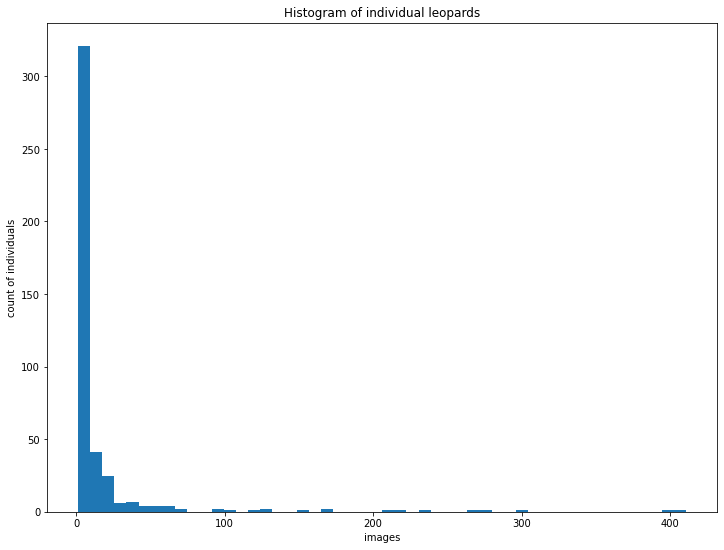

In [21]:
# Get individual leopard counts
lep_count=[individuals[leopard]['count'] for leopard in dict(list(individuals.items()))]

# Plot the histogram of images per individual leopard
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 9, forward=True)
ax.hist(lep_count, bins=50)
ax.set_title("Histogram of individual leopards")
ax.set_xlabel("images")
ax.set_ylabel("count of individuals")

## How balanced are the images based on the viewpoint?
We are trying to identify leopards based on their spots. We know that the pattern differ based on the flank or other body parts. For this reason, having a balanced set of orientations would help the model identify a specific leopard.

In [22]:
# Get all the viewpoints given an individual leopard
lep_left=[individuals[leopard]['left'] for leopard in dict(list(individuals.items()))]
lep_right=[individuals[leopard]['right'] for leopard in dict(list(individuals.items()))]
lep_front=[individuals[leopard]['front'] for leopard in dict(list(individuals.items()))]
lep_back=[individuals[leopard]['back'] for leopard in dict(list(individuals.items()))]
lep_down=[individuals[leopard]['down'] for leopard in dict(list(individuals.items()))]
lep_none=[individuals[leopard]['none'] for leopard in dict(list(individuals.items()))]

totalImgByView=[sum(lep_left), sum(lep_right),sum(lep_front),sum(lep_back),sum(lep_down),sum(lep_none)]

viewnames=['Left', 'Right', 'Front', 'Back', 'Down', "None"]

Text(0, 0.5, 'count of images')

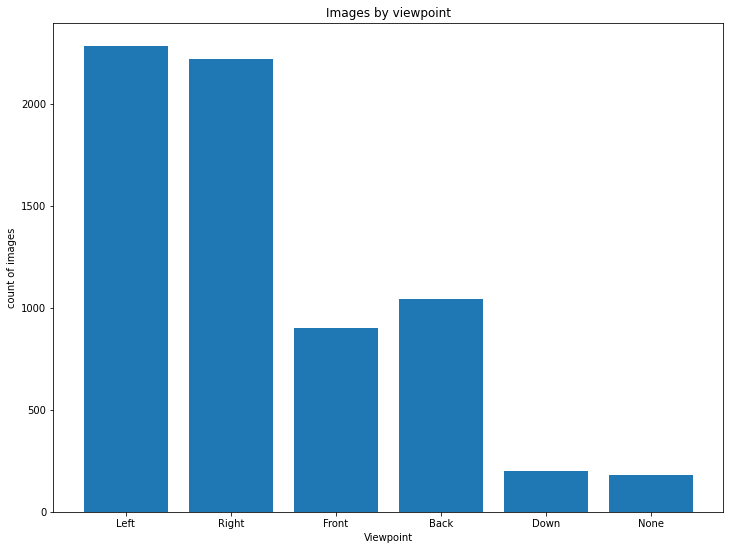

In [24]:
# plot the viewpoints
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 9, forward=True)
ax.bar(x=viewnames,height=totalImgByView)
ax.set_title("Images by viewpoint")
ax.set_xlabel("Viewpoint")
ax.set_ylabel("count of images")

## How imbalanced are the viewpoints by individual leopard?
Now we're plotting the viewpoints given each of the 431 individual leopards.

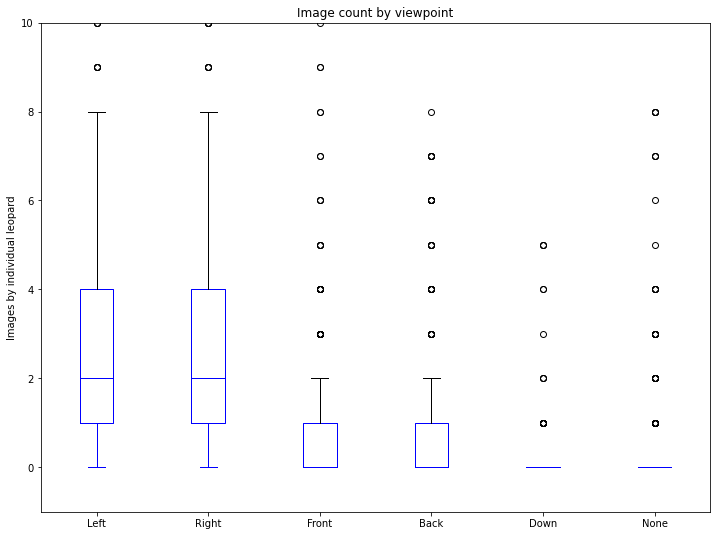

In [23]:
# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='blue')
    plt.setp(bp['caps'][0], color='blue')
    plt.setp(bp['whiskers'][0], color='blue')
    plt.setp(bp['fliers'][0], color='blue')
    plt.setp(bp['medians'][0], color='blue')

# Some fake data to plot
A = lep_left
B = lep_right
C = lep_front
D = lep_back
E = lep_down
F = lep_none

fig = plt.figure()
fig.set_size_inches(12, 9, forward=True)
ax = plt.axes()
# hold(True)

# first boxplot pair
bp = plt.boxplot(A
             , positions = [1]
             , widths = 0.6)
setBoxColors(bp)

# second boxplot pair
bp = plt.boxplot(B
             , positions = [3]
             , widths = 0.6)
setBoxColors(bp)

# thrid boxplot pair
bp = plt.boxplot(C
             , positions = [5]
             , widths = 0.6)
setBoxColors(bp)

# fourth boxplot pair
bp = plt.boxplot(D
             , positions = [7]
             , widths = 0.6)
setBoxColors(bp)

# fifth boxplot pair
bp = plt.boxplot(E
             , positions = [9]
             , widths = 0.6)
setBoxColors(bp)

# Sixth boxplot pair
bp = plt.boxplot(F
             , positions = [11]
             , widths = 0.6)
setBoxColors(bp)

# set axes limits and labels
ax.set_xlim(0,12)
ax.set_ylim(-1,10)
ax.set_xticklabels(viewnames)
ax.set_xticks([1,3,5,7,9,11])
ax.set_ylabel("Images by individual leopard")

plt.title("Image count by viewpoint")
plt.show()

We can see how most of the leopards have between two to four images from the left and right flank. While images from the front and back are scarce. About 25% of the individuals have only one from the front and back. There are some rare images with images from down. We also have some outlier classes which we would need to undersample.

# What is the image size distribution?

Text(0.5, 1.0, 'Height distribution')

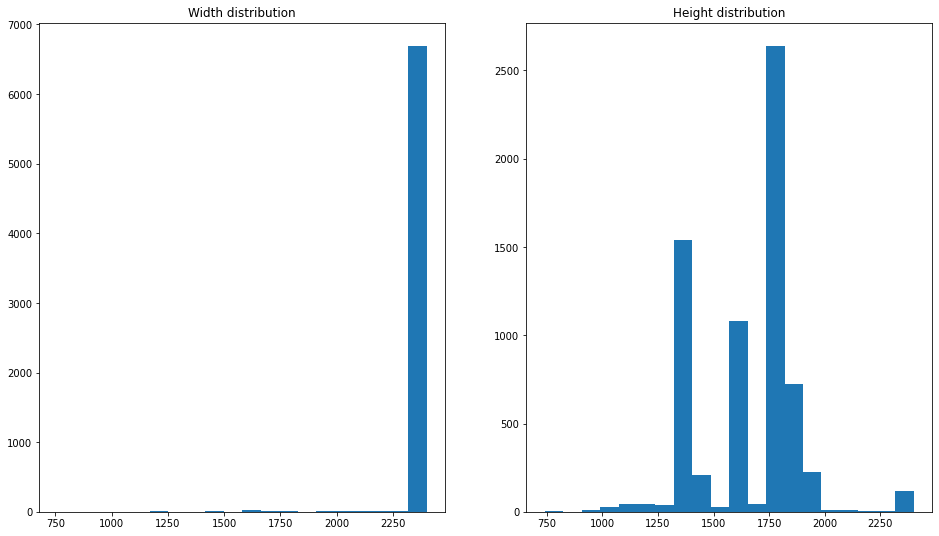

In [52]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 9, forward=True)

ax[0].hist(df.width, bins=20)
ax[0].set_title("Width distribution")
ax[1].hist(df.height, bins=20)
ax[1].set_title("Height distribution")

# What is the aspect ratio distribution?

Text(0.5, 1.0, 'Aspect Ratio Distribution (Height/Width)')

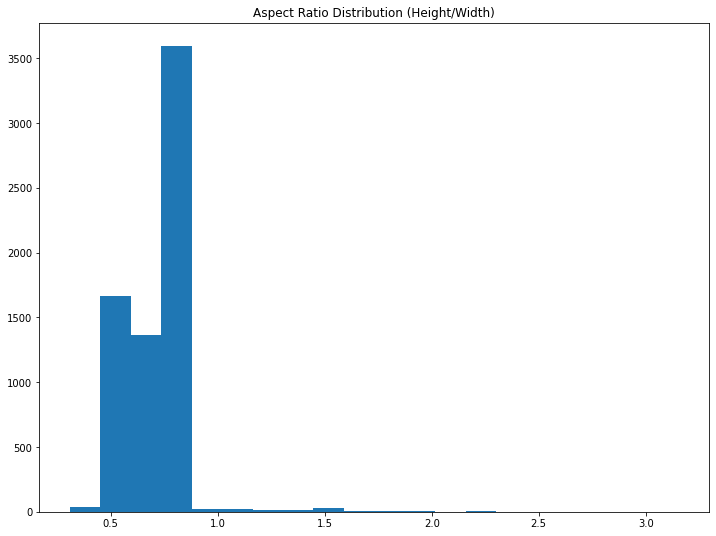

In [53]:
# Plot aspect ratio
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 9, forward=True)

plt.hist(df.height/df.width, bins=20)
plt.title("Aspect Ratio Distribution (Height/Width)")

# Fifty one dataset
Let's create a dataset on fifty one using the coco format (original)

In [5]:
# The directory containing the source images
data_path = "/mydrive/MIDS/W210/leopard.coco/images/train2022/"

# The path to the COCO labels JSON file
labels_path = "/mydrive/MIDS/W210/leopard.coco/annotations/instances_train2022.json"

# The path of train, test splits
output_path="/mydrive/MIDS/W210/Animal_Identification/datasets/leopard"


In [6]:
# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
    # label_types="detections",
    include_id=True,
    extra_attrs=['viewpoint']
)

 100% |███████████████| 6795/6795 [12.6s elapsed, 0s remaining, 561.8 samples/s]      


In [8]:
dataset.first()

<Sample: {
    'id': '629bec4b00147e0131403b7b',
    'media_type': 'image',
    'filepath': '/mydrive/MIDS/W210/leopard.coco/images/train2022/000000000001.jpg',
    'tags': BaseList([]),
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 2400,
        'height': 1800,
        'num_channels': None,
    }>,
    'detections': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '629bec4b00147e0131403b7a',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'leopard',
                'bounding_box': BaseList([
                    0.06792534722222222,
                    0.22887731481481483,
                    0.900607638888889,
                    0.6875,
                ]),
                'mask': None,
                'confidence': None,
                'index': None,
                'supercategory': 'animal',
                'iscrowd': 

In [ ]:
# Run Fifty One session
session = fo.launch_app(dataset)